In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D

def conv_block(input_tensor, filters, kernel_size=3):
    x = Conv2D(filters, kernel_size, activation='relu', padding='same')(input_tensor)
    x = Conv2D(filters, kernel_size, activation='relu', padding='same')(x)
    return x

def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    # Encoder
    conv1 = conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = conv_block(pool3, 512)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottom
    conv5 = conv_block(pool4, 1024)

    # Decoder
    up6 = UpSampling2D(size=(2, 2))(conv5)
    concat6 = concatenate([drop4, up6], axis=3)
    conv6 = conv_block(concat6, 512)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    concat7 = concatenate([conv3, up7], axis=3)
    conv7 = conv_block(concat7, 256)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    concat8 = concatenate([conv2, up8], axis=3)
    conv8 = conv_block(concat8, 128)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    concat9 = concatenate([conv1, up9], axis=3)
    conv9 = conv_block(concat9, 64)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(conv9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [2]:
import os
import cv2
import glob
import pickle
import numpy as np
from tqdm import tqdm
from keras.metrics import MeanIoU
from keras.utils import normalize
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
import segmentation_models as sm
from sklearn.metrics import average_precision_score

SIZE_X = 128 
SIZE_Y = 128
n_classes=10
BACKBONE = 'mobilenetv2'
parent_directory = r'E:\Segmentation\datasets\FloodNet-Supervised_v1.0'

Segmentation Models: using `keras` framework.


In [3]:
def load_images(parent_directory, split='train'):
    images = []
    masks = [] 

    image_folder_path = f'{parent_directory}\{split}\{split}-org-img'
    for img_path in tqdm(glob.glob(os.path.join(image_folder_path, "*.jpg"))):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        images.append(img)

        mask_path = (img_path.replace('org', 'label')).replace('jpg', 'png')
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        masks.append(mask)
                
    images = np.array(images)
    masks = np.array(masks)

    print(f'{split.upper()}: Images loaded: {images.shape[0]}')
    print(f'{split.upper()}: Masks loaded: {masks.shape[0]}')

    return images, masks

In [4]:
def preprocess_data(images, masks, unet_preporcessing):
    if unet_preporcessing:
        images = unet_preporcessing(images)
    else:
        images = normalize(images, axis=1)
        
    masks = np.expand_dims(masks, axis=-1)
    masks = to_categorical(masks, num_classes=n_classes)
    masks = masks.reshape((masks.shape[0], masks.shape[1], masks.shape[2], n_classes))

    return images, masks

In [5]:
class_map= {'Background':0, 'Building-flooded':1, 'Building-non-flooded':2, 'Road-flooded':3, 'Road-non-flooded':4, 'Water':5, 'Tree':6, 'Vehicle':7, 'Pool':8, 'Grass':9}
    
color_map = {'Background':[0, 0, 0], 'Building-flooded':[196, 0, 0], 'Building-non-flooded': [255,128,128], 'Road-flooded':[128, 128, 0],  'Road-non-flooded':[128, 128, 128], 
                 'Water': [0, 191, 255], 'Tree':[34, 139, 34], 'Vehicle': [123, 37, 118],  'Pool':[0, 68, 255],'Grass':[127, 224, 104]}

handles = [Rectangle((0,0),1,1, color = (np.array(c)/255)) for n,c in color_map.items()]

labels = [n for n,c in color_map.items()]


def to_RGB(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """    
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    for key, val in class_map.items():
      label_seg [np.all(label == class_map[key],axis=-1)] = color_map[key]  
    return label_seg

def display_images_with_masks(image, mask, predicted):
    plt.figure(figsize=(12, 8))
    plt.subplot(131)
    plt.title('Testing Image')
    plt.imshow(image)
    plt.subplot(132)
    plt.title('Testing Label')
    plt.imshow(to_RGB(np.tile(np.expand_dims(mask, axis=-1), (1, 1, 3)))) 
    plt.subplot(133)
    plt.title('Prediction')
    plt.imshow(to_RGB(np.tile(np.expand_dims(predicted, axis=-1), (1, 1, 3))))
    plt.legend(handles, labels, bbox_to_anchor =(-0.8,-0.5), loc='lower center', ncol=5)
    plt.show()

In [29]:
#Load the images
train_images, train_masks = load_images(parent_directory, split='train')
val_images, val_masks = load_images(parent_directory, split='val')

100%|██████████| 1445/1445 [06:57<00:00,  3.46it/s]


TRAIN: Images loaded: 1445
TRAIN: Masks loaded: 1445


100%|██████████| 450/450 [02:05<00:00,  3.60it/s]

VAL: Images loaded: 450
VAL: Masks loaded: 450


In [6]:
pickle_file_path = 'dataset/train_and_val_data.pickle'

with open(pickle_file_path, 'rb') as pickle_file:
    loaded_data = pickle.load(pickle_file)

train_images = loaded_data['train_images']
train_masks = loaded_data['train_masks']
val_images = loaded_data['val_images']
val_masks = loaded_data['val_masks']

print('Shapes of loaded data:')
print('Train Images:', train_images.shape)
print('Train Masks:', train_masks.shape)
print('Val Images:', val_images.shape)
print('Val Masks:', val_masks.shape)

Shapes of loaded data:
Train Images: (1445, 128, 128, 3)
Train Masks: (1445, 128, 128)
Val Images: (450, 128, 128, 3)
Val Masks: (450, 128, 128)


In [7]:
import segmentation_models as sm

preprocess_input = sm.get_preprocessing(BACKBONE)

train_images, train_masks = preprocess_data(train_images, train_masks, preprocess_input)
val_images, val_masks = preprocess_data(val_images, val_masks, preprocess_input)

print('Shapes of loaded data:')
print('Train Images:', train_images.shape)
print('Train Masks:', train_masks.shape)
print('Val Images:', val_images.shape)
print('Val Masks:', val_masks.shape)

Shapes of loaded data:
Train Images: (1445, 128, 128, 3)
Train Masks: (1445, 128, 128, 10)
Val Images: (450, 128, 128, 3)
Val Masks: (450, 128, 128, 10)


In [8]:
IMG_HEIGHT = SIZE_X
IMG_WIDTH  = SIZE_Y
IMG_CHANNELS = 3

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss=sm.losses.bce_jaccard_loss, metrics=sm.metrics.iou_score)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

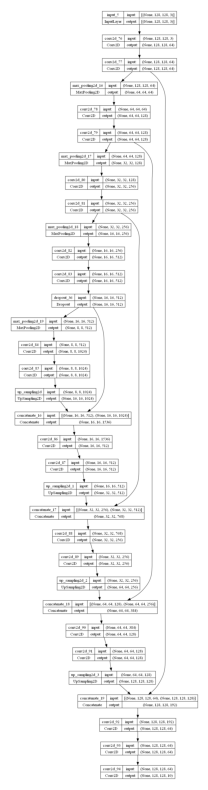

In [20]:
plot_model(model, to_file='multi_unet_model.png', show_shapes=True, show_layer_names=True)

img = plt.imread('multi_unet_model.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

In [10]:
history = model.fit(train_images, train_masks, batch_size = 16, verbose=1, epochs=50, validation_data=(val_images, val_masks), shuffle=False)

Epoch 1/50
91/91 [==============================] - 25s 175ms/step - loss: 2.9801 - iou_score: 0.0534 - val_loss: 1.1850 - val_iou_score: 0.0555
Epoch 2/50
91/91 [==============================] - 13s 141ms/step - loss: 1.1554 - iou_score: 0.0742 - val_loss: 1.1299 - val_iou_score: 0.0879
Epoch 3/50
91/91 [==============================] - 13s 142ms/step - loss: 1.1430 - iou_score: 0.0812 - val_loss: 1.1235 - val_iou_score: 0.0877
Epoch 4/50
91/91 [==============================] - 13s 145ms/step - loss: 1.1182 - iou_score: 0.0883 - val_loss: 1.1148 - val_iou_score: 0.1031
Epoch 5/50
91/91 [==============================] - 13s 142ms/step - loss: 1.0987 - iou_score: 0.0974 - val_loss: 1.1439 - val_iou_score: 0.1076
Epoch 6/50
91/91 [==============================] - 13s 143ms/step - loss: 1.0881 - iou_score: 0.1041 - val_loss: 1.0833 - val_iou_score: 0.1118
Epoch 7/50
91/91 [==============================] - 13s 143ms/step - loss: 1.0709 - iou_score: 0.1125 - val_loss: 1.0698 - val_iou

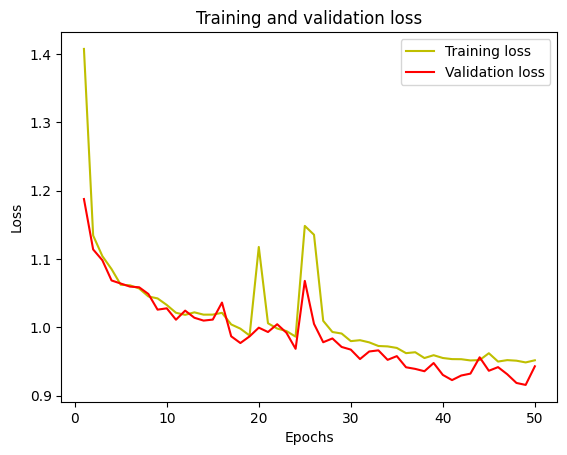

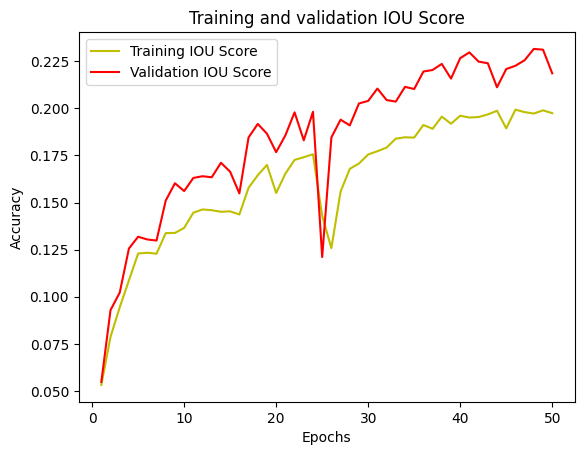

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU Score')
plt.plot(epochs, val_acc, 'r', label='Validation IOU Score')
plt.title('Training and validation IOU Score')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
model.save(f'UNet_simple_model({BACKBONE})_with_50_epochs.hdf5')

In [ ]:
model.load_weights(f'UNet_simple_model({BACKBONE})_with_50_epochs.hdf5')

In [6]:
test_images, test_masks = load_images(parent_directory, split='test')
test_masks = np.expand_dims(test_masks, axis=-1)
test_masks_cat = to_categorical(test_masks, num_classes=n_classes)
test_masks_cat = test_masks_cat.reshape((test_masks.shape[0], test_masks.shape[1], test_masks.shape[2], n_classes))
test_images_seperate = test_images
test_images = normalize(test_images, axis=1)

print(f'\nImages Shape: {test_images[0].shape}')
print(f'Masks Shape: {test_masks_cat[0].shape}')

  0%|          | 0/448 [00:00<?, ?it/s]

100%|██████████| 448/448 [02:07<00:00,  3.51it/s]


TEST: Images loaded: 448
TEST: Masks loaded: 448

Images Shape: (128, 128, 3)
Masks Shape: (128, 128, 10)


In [23]:
pickle_file_path = 'dataset/test_data.pickle'

with open(pickle_file_path, 'rb') as pickle_file:
    loaded_data = pickle.load(pickle_file)

test_images = loaded_data['test_images']
test_masks = loaded_data['test_masks']
test_images_seperate = loaded_data['test_images_seperate']

test_images, test_masks = preprocess_data(test_images, test_masks, preprocess_input)

print('Shapes of loaded data:')
print('Test Images:', test_images.shape)
print('Test Masks:', test_masks.shape)

Shapes of loaded data:
Test Images: (448, 128, 128, 3)
Test Masks: (448, 128, 128, 10)


In [24]:
_, acc = model.evaluate(test_images, test_masks, verbose=0)
print("Accuracy is = ", (acc * 100.0), "%")

Accuracy is =  21.375374495983124 %


In [25]:
from keras.metrics import MeanIoU
import numpy as np

y_pred = model.predict(test_images)
predicted_masks = np.argmax(y_pred, axis=-1)
test_masks_ = np.argmax(test_masks, axis=-1)

print(predicted_masks.shape)
print(test_masks_.shape)

14/14 [==============================] - 1s 74ms/step
(448, 128, 128)
(448, 128, 128)


In [26]:
class_names = ["Background", "Building Flooded", "Building Non-Flooded", "Road Flooded", "Road Non-Flooded",
               "Water", "Tree", "Vehicle", "Pool", "Grass"]

n_classes = len(class_names)  
IOU_keras = MeanIoU(num_classes=n_classes)

IOU_keras.update_state(test_masks_, predicted_masks)
print("Mean IoU =", IOU_keras.result().numpy())

values = np.array(IOU_keras.get_weights())
values = values.reshape(n_classes, n_classes)

class_IoUs = []
print("IoU for each class:")
for i in range(n_classes):
    class_IoU = values[i, i] / (np.sum(values[i, :]) + np.sum(values[:, i]) - values[i, i])
    class_IoUs.append(class_IoU)
    print(f"{class_names[i]}: {class_IoU}")

class_APs = []

for i in range(n_classes):
    class_predicted_masks = (predicted_masks == i).astype(int)
    class_test_masks = (test_masks_ == i).astype(int)
    
    class_predicted_masks_flat = class_predicted_masks.flatten().reshape(-1, 1)
    class_test_masks_flat = class_test_masks.flatten().reshape(-1, 1)
    
    class_APs.append(average_precision_score(class_test_masks_flat, class_predicted_masks_flat, average='micro'))

mAP_score = np.mean(class_APs)
print("Overall mAP score =", mAP_score)

Mean IoU = 0.26772338
IoU for each class:
Background: 0.0
Building Flooded: 0.16328397393226624
Building Non-Flooded: 0.38120603561401367
Road Flooded: 0.0
Road Non-Flooded: 0.486294150352478
Water: 0.3077756464481354
Tree: 0.3533005118370056
Vehicle: 0.19037774205207825
Pool: 0.2571451961994171
Grass: 0.5378507375717163
Overall mAP score = 0.2504538134183326


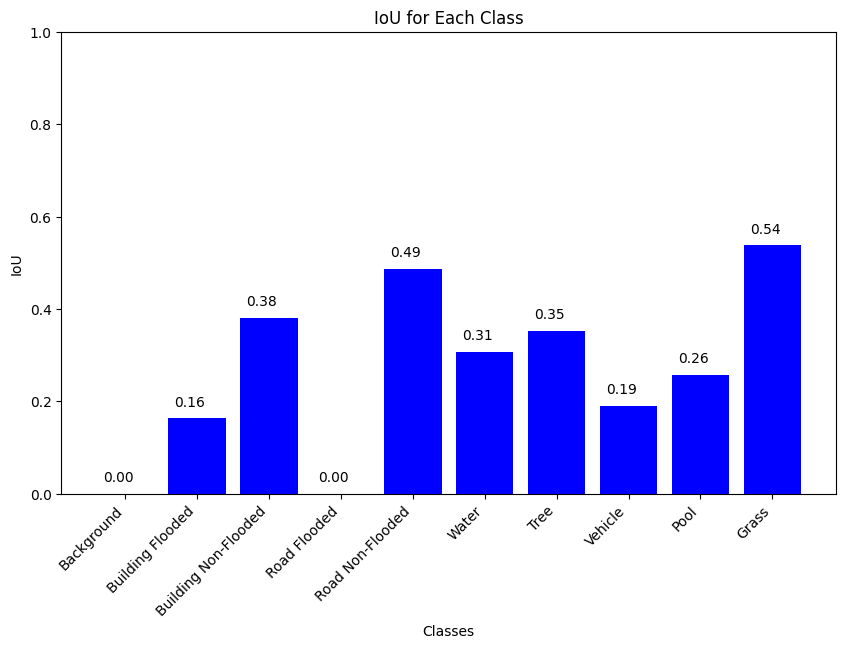

In [27]:
plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, class_IoUs, color='blue')
plt.title(f'IoU for Each Class')
plt.xlabel('Classes')
plt.ylabel('IoU')
plt.ylim(0, 1) 
plt.xticks(rotation=45, ha='right')  

for bar, value in zip(bars, class_IoUs):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.02, f'{value:.2f}', ha='center', va='bottom')

plt.show()

In [28]:
def display_random_function():
    image_id = np.random.randint(0, len(test_images))
    image = test_images_seperate[image_id]
    ground_truth_mask = test_masks_[image_id]
    predicted_mask = predicted_masks[image_id]

    print(f'Image Shape: {image.shape}')
    print(f'Ground Truth Mask Shape: {ground_truth_mask.shape}')
    print(f'Predicted Mask Shape: {predicted_mask.shape}')

    display_images_with_masks(image, ground_truth_mask, predicted_mask)

Image Shape: (128, 128, 3)
Ground Truth Mask Shape: (128, 128)
Predicted Mask Shape: (128, 128)


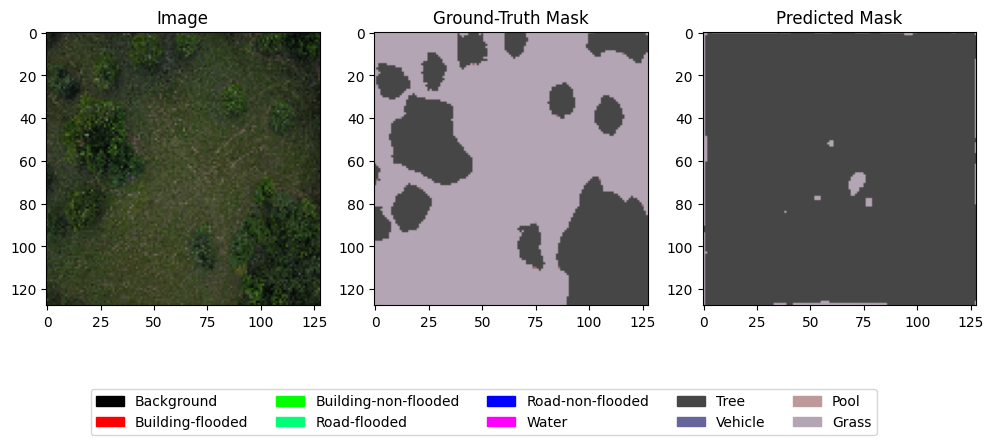

In [29]:
display_random_function()

Image Shape: (128, 128, 3)
Ground Truth Mask Shape: (128, 128)
Predicted Mask Shape: (128, 128)


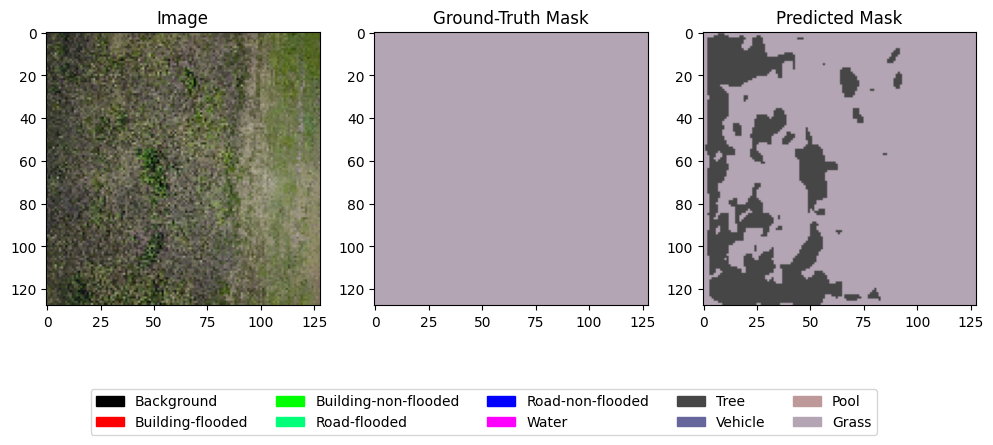

In [30]:
display_random_function()

Image Shape: (128, 128, 3)
Ground Truth Mask Shape: (128, 128)
Predicted Mask Shape: (128, 128)


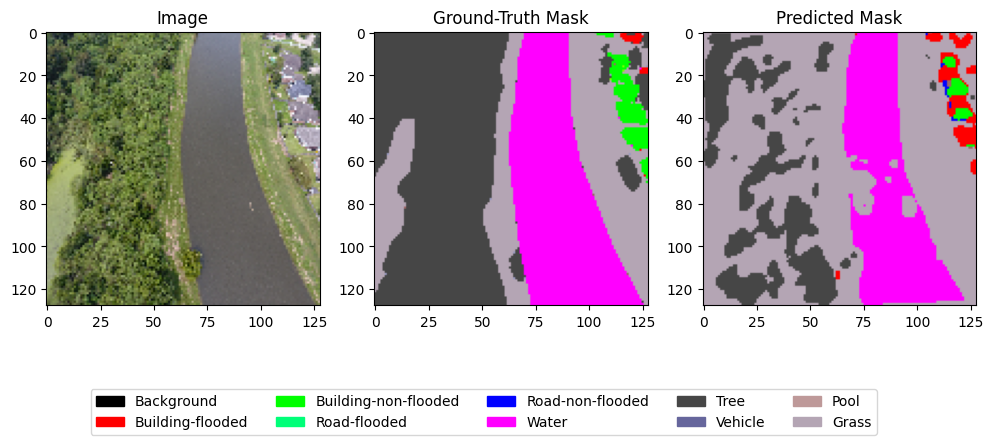

In [31]:
display_random_function()

Image Shape: (128, 128, 3)
Ground Truth Mask Shape: (128, 128)
Predicted Mask Shape: (128, 128)


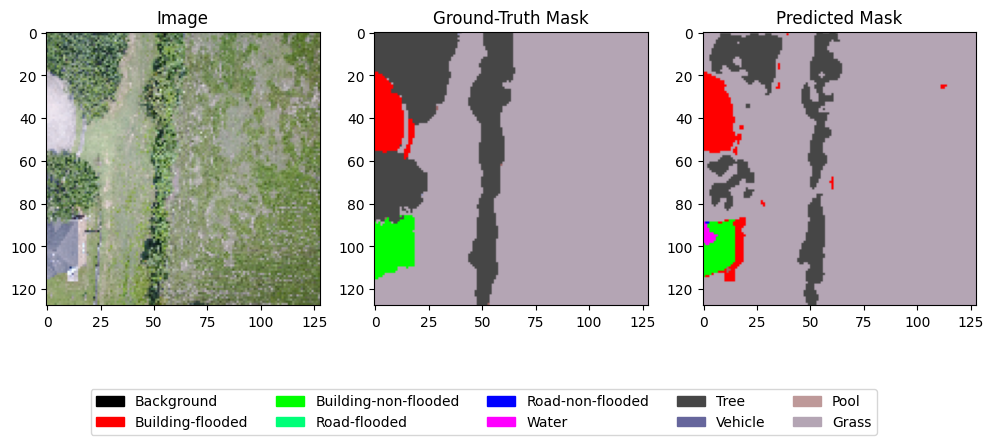

In [32]:
display_random_function()

Image Shape: (128, 128, 3)
Ground Truth Mask Shape: (128, 128)
Predicted Mask Shape: (128, 128)


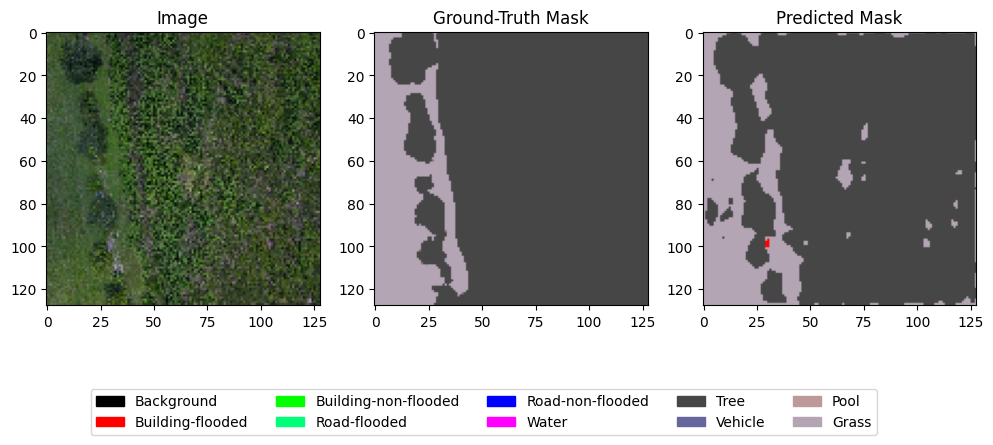

In [33]:
display_random_function()

Image Shape: (128, 128, 3)
Ground Truth Mask Shape: (128, 128)
Predicted Mask Shape: (128, 128)


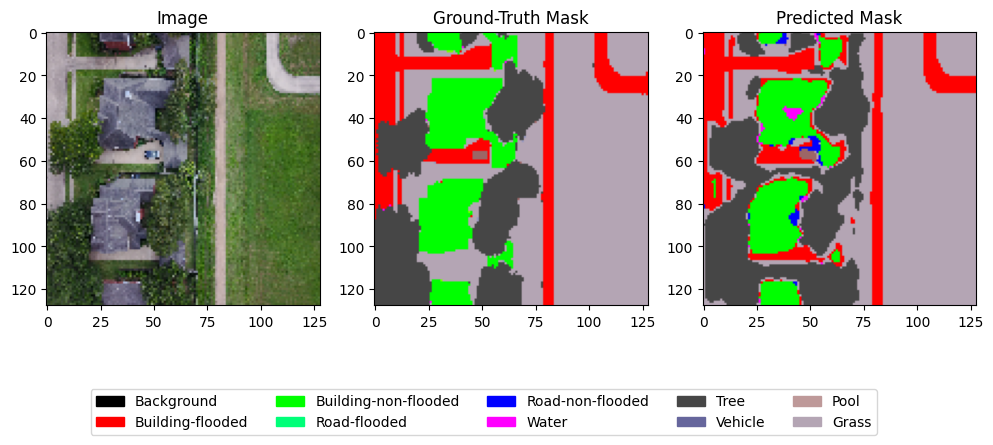

In [34]:
display_random_function()